In [577]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn.functional as F

# REINFORCE

![Pendulum](imgs/pendulum.gif)

In [578]:
env = gym.make('Pendulum-v1', g=9.81)

In [579]:
nS = env.observation_space.low.size
nA = env.action_space.low.size
nH = 512

In [580]:
gamma = 0.99
tau = 0.95
alpha = 1e-4
options = {"x_init": 0.01, "y_init": 0.01}

In [581]:
max_episodes = 15000
max_steps = 30

In [582]:
actor = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
)

In [583]:
critic = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
)

In [584]:
log_sigma = torch.ones(1, dtype=torch.double, requires_grad=True)

In [585]:
opt_actor = torch.optim.Adam(list(actor.parameters()) + [log_sigma], lr=alpha)
opt_critic = torch.optim.Adam(actor.parameters(), lr=alpha)

In [586]:
class Buffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.terminals = []

    def clear(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.terminals = []

    def __len__(self):
        return len(self.states)

In [587]:
def select_action(actor, log_sigma, s):
    mu = actor(torch.as_tensor(s))
    sigma = log_sigma.exp()
    pi = torch.distributions.Normal(mu, sigma)

    a = pi.sample()
    a_logprob = pi.log_prob(a)
    
    return a, a_logprob

In [588]:
def calculate_returns(values, buffer):
    returns = []
    advantages=[]

    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for i in reversed(range(len(buffer))):
        reward = buffer.rewards[i]
        mask = 1 - buffer.terminals[i]

        actual_return = reward + gamma*prev_return*mask
        actual_delta = reward + gamma*prev_value*mask - values[i]
        actual_advantage = actual_delta + gamma*tau*prev_advantage*mask        

        returns.insert(0, actual_return)
        advantages.insert(0, actual_advantage)

        prev_return = actual_return
        prev_value = values[i]
        prev_advantage = actual_advantage

    returns = torch.as_tensor(returns)
    advantages = torch.as_tensor(advantages)

    return returns, advantages

In [589]:
def train(actor, critic, opt_actor, opt_critic, buffer):
    states = torch.as_tensor(buffer.states)
    logprobs = torch.stack(buffer.logprobs)
    
    values = critic(states).flatten()
    returns, advantages = calculate_returns(values, buffer)
            
    # Actor
    loss_action = torch.mean(-logprobs*advantages)
    opt_actor.zero_grad()
    loss_action.backward()
    opt_actor.step()

    # Critic
    criterion = torch.nn.MSELoss()
    loss_value = criterion(values, returns)
    opt_critic.zero_grad()
    loss_value.backward()
    opt_critic.step()
    
    buffer.clear()

In [590]:
Rs = []
buffer = Buffer()
for episode in range(max_episodes):
    s, _ = env.reset(options=options)
    R = 0
    for step in range(max_steps):
        a, a_logprob = select_action(actor, log_sigma, s)
        s_prime, r, done, _, _ = env.step(a)
        
        buffer.states.append(s)
        buffer.actions.append(a)
        buffer.logprobs.append(a_logprob)
        buffer.rewards.append(r)
        buffer.terminals.append(done)
        R += r

        if done:
            break
            
        s = s_prime
    train(actor, critic, opt_actor, opt_critic, buffer)
    Rs.append(R)

In [591]:
mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)

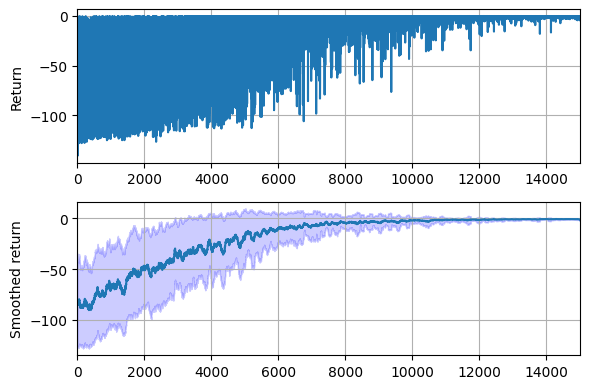

In [592]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Rs)
axes[0].set_xlim(0, max_episodes)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(mean)
axes[1].fill_between(time, mean - std, mean + std, color='b', alpha=0.2)
axes[1].set_xlim(0, max_episodes)
axes[1].grid()
axes[1].set_ylabel("Smoothed return")
plt.tight_layout()
plt.show()